# Build Models

### Imports / Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from tabpfn import TabPFNRegressor

In [2]:
# Set pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Read In Data

In [3]:
df = pd.read_csv("..\\Data\\NFLData.csv")
df = df[df['points'].notna() & df['avg_passing_epa'].notna()]
y_actual = df[df['points'].notna() & df['avg_passing_epa'].isna()]

## Exploration

In [4]:
def convert_to_decimal(time_value):
    if isinstance(time_value, str) and ':' in time_value:
        minutes, seconds = time_value.split(':')
        return float(minutes) + float(seconds) / 60
    return time_value  # Return as-is if already float or NaN

# Process both columns
df['team_top'] = df['team_top'].apply(convert_to_decimal).astype(float)
df['opp_top'] = df['opp_top'].apply(convert_to_decimal).astype(float)

In [5]:
df.isna().sum()

game_id                           0
week                              0
team                              0
opponent                          0
points                            0
avg_passing_epa                   0
avg_passing_cpoe                  0
avg_rushing_epa                   0
avg_receiving_epa                 0
avg_fg_pct                        0
avg_pat_pct                       0
avg_completions                   0
avg_attempts                      0
avg_passing_yards                 0
avg_passing_tds                   0
avg_passing_interceptions         0
avg_sacks_suffered                0
avg_sack_yards_lost               0
avg_sack_fumbles_lost             0
avg_carries                       0
avg_rushing_yards                 0
avg_rushing_tds                   0
avg_rushing_fumbles_lost          0
avg_rushing_first_downs           0
avg_receiving_fumbles_lost        0
avg_penalties                     0
avg_penalty_yards                 0
avg_punt_returns            

In [6]:
df.describe()

,week,points,avg_passing_epa,avg_passing_cpoe,avg_rushing_epa,avg_receiving_epa,avg_fg_pct,avg_pat_pct,avg_completions,avg_attempts,avg_passing_yards,avg_passing_tds,avg_passing_interceptions,avg_sacks_suffered,avg_sack_yards_lost,avg_sack_fumbles_lost,avg_carries,avg_rushing_yards,avg_rushing_tds,avg_rushing_fumbles_lost,avg_rushing_first_downs,avg_receiving_fumbles_lost,avg_penalties,avg_penalty_yards,avg_punt_returns,avg_punt_return_yards,avg_kickoff_returns,avg_kickoff_return_yards,avg_fg_att,avg_def_tackles_solo,avg_def_tackles_with_assist,avg_def_tackle_assists,avg_def_tackles_for_loss,avg_def_tackles_for_loss_yards,avg_def_fumbles_forced,avg_def_sacks,avg_def_sack_yards,avg_def_qb_hits,avg_def_interceptions,avg_def_interception_yards,avg_def_pass_defended,avg_def_tds,avg_def_fumbles,avg_def_safeties,team_top,opp_top
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,5.369748,23.735294,1.598231,1.353354,-0.503541,6.068874,0.842936,0.949373,21.420718,32.685779,226.068727,1.491762,0.643422,2.288580,-14.852856,0.130402,26.135584,112.555827,0.893848,0.160134,6.728772,0.089396,7.216116,57.853121,1.690056,19.067512,4.007028,102.098724,2.138350,37.432448,2.024700,27.454542,4.900865,20.190221,0.644508,2.270918,14.715811,5.505362,0.637825,7.510769,4.285504,0.034779,0.061875,0.012875,29.990056,29.990056
std,2.294244,10.025353,6.459583,5.673615,2.961801,5.505925,0.155568,0.114283,3.392358,5.001191,40.721230,0.607864,0.491960,1.047939,7.586025,0.207415,4.038995,29.146774,0.617659,0.224638,1.814509,0.172144,1.665100,16.097758,0.785104,11.691254,1.078548,30.494882,0.729426,3.725420,1.094063,4.742510,1.307251,7.542758,0.504185,0.966394,7.072319,1.973163,0.543929,9.693433,1.584212,0.102034,0.139459,0.048655,1.774112,1.774112
min,2.000000,0.000000,-16.142569,-13.457901,-9.176746,-11.740281,0.250000,0.000000,12.000000,19.000000,112.000000,0.000000,0.000000,0.000000,-50.000000,0.000000,12.000000,46.000000,0.000000,0.000000,2.000000,0.000000,3.000000,15.000000,0.000000,0.000000,1.000000,11.000000,0.000000,26.000000,0.000000,8.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.633333,26.633333
25%,3.000000,17.000000,-2.109636,-2.449615,-2.500505,2.330627,0.750000,0.945833,19.333333,29.333333,201.800000,1.000000,0.297619,1.500000,-18.093750,0.000000,23.700000,93.964286,0.500000,0.000000,5.678571,0.000000,6.000000,47.541667,1.129464,11.250000,3.381250,84.750000,1.666667,35.375000,1.333333,24.678571,4.000000,15.500000,0.285714,1.578571,9.000000,4.407143,0.250000,0.000000,3.166667,0.000000,0.000000,0.000000,28.450000,28.450000
50%,5.000000,24.000000,1.595249,1.094666,-0.360594,6.013418,0.845833,1.000000,21.083333,32.500000,222.750000,1.500000,0.585714,2.071429,-13.333333,0.000000,26.250000,112.812500,0.833333,0.000000,6.775000,0.000000,7.000000,56.916667,1.625000,17.619048,4.000000,101.000000,2.000000,37.354167,1.800000,27.291667,5.000000,19.708333,0.571429,2.083333,13.690476,5.333333,0.500000,4.387500,4.250000,0.000000,0.000000,0.000000,30.000000,30.000000
75%,7.000000,30.000000,6.712971,4.826453,1.115578,10.044814,1.000000,1.000000,23.000000,35.500000,253.428571,1.870536,1.000000,3.000000,-10.000000,0.200000,28.371429,129.940476,1.191667,0.285714,7.714286,0.142857,8.276786,67.000000,2.000000,25.458333,4.592857,118.023810,2.500000,39.553571,2.500000,30.625000,5.666667,24.428571,1.000000,2.870536,18.729167,6.264286,1.000000,11.964286,5.000000,0.000000,0.000000,0.000000,31.566667,31.566667
max,9.000000,52.000000,17.567262,2

In [7]:
numeric_cols = df.select_dtypes(include='number').columns

correlation_matrix = df[numeric_cols].corr()

In [8]:
correlation_matrix[correlation_matrix.abs() > 0.5].dropna(how='all', axis=0).dropna(how='all', axis=1)

,week,points,avg_passing_epa,avg_passing_cpoe,avg_rushing_epa,avg_receiving_epa,avg_fg_pct,avg_pat_pct,avg_completions,avg_attempts,avg_passing_yards,avg_passing_tds,avg_passing_interceptions,avg_sacks_suffered,avg_sack_yards_lost,avg_sack_fumbles_lost,avg_carries,avg_rushing_yards,avg_rushing_tds,avg_rushing_fumbles_lost,avg_rushing_first_downs,avg_receiving_fumbles_lost,avg_penalties,avg_penalty_yards,avg_punt_returns,avg_punt_return_yards,avg_kickoff_returns,avg_kickoff_return_yards,avg_fg_att,avg_def_tackles_solo,avg_def_tackles_with_assist,avg_def_tackle_assists,avg_def_tackles_for_loss,avg_def_tackles_for_loss_yards,avg_def_fumbles_forced,avg_def_sacks,avg_def_sack_yards,avg_def_qb_hits,avg_def_interceptions,avg_def_interception_yards,avg_def_pass_defended,avg_def_tds,avg_def_fumbles,avg_def_safeties,team_top,opp_top
week,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_passing_epa,NaN,NaN,1.000000,0.656479,NaN,0.935068,NaN,NaN,NaN,NaN,0.660139,0.562700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_passing_cpoe,NaN,NaN,0.656479,1.000000,NaN,0.666248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rushing_epa,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636212,0.556716,NaN,0.573745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_receiving_epa,NaN,NaN,0.935068,0.666248,NaN,1.000000,NaN,NaN,NaN,NaN,0.636940,0.586152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_fg_pct,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_pat_pct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_completions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.848487,0.689768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_attempts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.848487,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
correlation_matrix['points'][correlation_matrix['points'].abs() > 0.05]

points                        1.000000
avg_passing_epa               0.179031
avg_passing_cpoe              0.154030
avg_rushing_epa               0.074477
avg_receiving_epa             0.126109
avg_fg_pct                    0.052235
avg_completions               0.080602
avg_passing_yards             0.075692
avg_passing_interceptions    -0.103222
avg_sacks_suffered           -0.153548
avg_sack_yards_lost           0.192879
avg_sack_fumbles_lost        -0.104610
avg_carries                   0.056183
avg_rushing_yards             0.065027
avg_rushing_tds               0.144418
avg_rushing_first_downs       0.068644
avg_receiving_fumbles_lost    0.058267
avg_penalties                -0.093671
avg_penalty_yards            -0.091185
avg_kickoff_returns          -0.067918
avg_kickoff_return_yards     -0.069614
avg_fg_att                   -0.069659
avg_def_fumbles_forced       -0.081686
avg_def_qb_hits               0.050543
avg_def_pass_defended        -0.100897
team_top                 

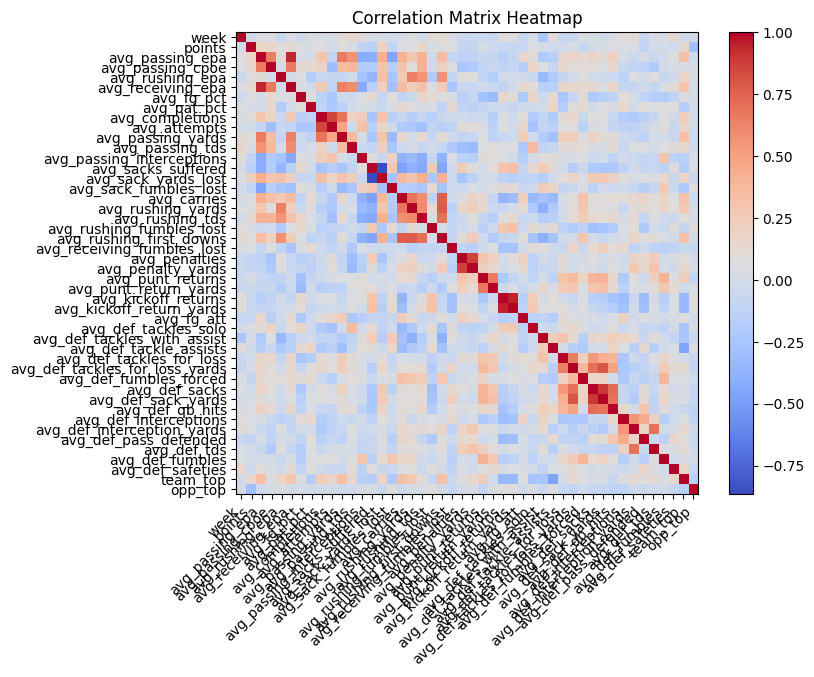

In [10]:
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation Matrix Heatmap")
plt.show()

### Train-Test Split and Variable Selection

In [11]:
# Exclude highly correlated variables that are less highly coorelated with the target than the other variable correlated

exclude_cols = ["game_id", "week", "team", "opponent", "opponent_team", "points", "avg_receiving_epa", "avg_passing_yards", "avg_attempts", "avg_sack_yards_lost", "avg_carries", "avg_rushing_first_downs",
                "avg_penalty_yards", "avg_punt_returns", "avg_kickoff_return_yards", "avg_def_tackles_for_loss", "avg_def_sacks", "avg_def_sack_yards"]
X = df.drop(columns=exclude_cols)
y = df['points']

In [12]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [13]:
# Reset pandas settings
pd.reset_option('all')

C:\Users\tyler\AppData\Local\Temp\ipykernel_34312\4019361738.py:2: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\tyler\AppData\Local\Temp\ipykernel_34312\4019361738.py:2: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


In [14]:
X_train

,avg_passing_epa,avg_passing_cpoe,avg_rushing_epa,avg_fg_pct,avg_pat_pct,avg_completions,avg_passing_tds,avg_passing_interceptions,avg_sacks_suffered,avg_sack_fumbles_lost,...,avg_def_fumbles_forced,avg_def_qb_hits,avg_def_interceptions,avg_def_interception_yards,avg_def_pass_defended,avg_def_tds,avg_def_fumbles,avg_def_safeties,team_top,opp_top
321,-2.995946,-0.656972,1.147158,0.800000,0.900000,22.200000,1.600000,0.800000,1.800000,0.400000,...,0.200000,2.200000,0.800000,15.000000,3.000000,0.200000,0.200000,0.0,31.566667,29.133333
361,-0.641723,1.543883,-0.010964,0.944444,1.000000,21.375000,1.875000,1.250000,2.250000,0.125000,...,0.750000,4.000000,0.125000,0.875000,2.500000,0.000000,0.000000,0.0,28.383333,28.600000
331,0.704867,-3.441461,-0.937591,0.666667,1.000000,20.750000,0.750000,0.750000,1.250000,0.000000,...,0.750000,5.750000,0.750000,0.000000,4.000000,0.000000,0.000000,0.0,30.166667,33.416667
95,5.591790,2.416233,2.876569,0.900000,1.000000,20.500000,1.833333,0.666667,2.000000,0.000000,...,1.333333,4.666667,0.333333,4.666667,2.666667,0.000000,0.166667,0.0,33.416667,31.566667
364,10.429720,7.559796,0.255268,0.809524,0.971429,21.571429,1.857143,0.285714,1.428571,0.142857,...,0.285714,8.142857,0.285714,0.000000,4.142857,0.000000,0.142857,0.0,30.333333,31.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,2.332388,-3.302175,-1.303559,0.841667,1.000000,20.000000,1.285714,0.571429,1.714286,0.000000,...,0.714286,4.285714,1.571429,29.142857,4.000000,0.142857,0.000000,0.0,31.433333,26.816667
14,5.766234,-10.401314,0.506000,0.500000,0.666667,17.000000,3.000000,0.000000,1.000000,0.000000,...,0.000000,4.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.0,30.983333,32.683333
92,-1.550870,-0.585452,-2.343185,0.833333,1.000000,20.333333,1.333333,1.166667,3.833333,0.166667,...,1.333333,4.500000,0.333333,14.500000,2.500000,0.166667,0.166667,0.0,28.550000,33.150000
316,7.518173,4.111742,5.123602,0.875000,1.000000,21.500000,1.750000,0.250000,1.750000,0.000000,...,1.500000,4.000000,0.500000,7.000000,2.500000,0.000000,0.250000,0.0,33.416667,31.833333


In [15]:
y_train

321    30.0
361     6.0
331    24.0
95     40.0
364    13.0
       ... 
106    47.0
14     20.0
92     10.0
316    20.0
102    14.0
Name: points, Length: 190, dtype: float64


## Models

### LASSO Regression to Potentially cut down on more features

In [16]:
X_train.columns

Index(['avg_passing_epa', 'avg_passing_cpoe', 'avg_rushing_epa', 'avg_fg_pct',
       'avg_pat_pct', 'avg_completions', 'avg_passing_tds',
       'avg_passing_interceptions', 'avg_sacks_suffered',
       'avg_sack_fumbles_lost', 'avg_rushing_yards', 'avg_rushing_tds',
       'avg_rushing_fumbles_lost', 'avg_receiving_fumbles_lost',
       'avg_penalties', 'avg_punt_return_yards', 'avg_kickoff_returns',
       'avg_fg_att', 'avg_def_tackles_solo', 'avg_def_tackles_with_assist',
       'avg_def_tackle_assists', 'avg_def_tackles_for_loss_yards',
       'avg_def_fumbles_forced', 'avg_def_qb_hits', 'avg_def_interceptions',
       'avg_def_interception_yards', 'avg_def_pass_defended', 'avg_def_tds',
       'avg_def_fumbles', 'avg_def_safeties', 'team_top', 'opp_top'],
      dtype='object')

In [17]:
# Standard scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Fit a Lasso model with cross-validation to choose the best alpha (penalty strength)
lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)

In [19]:
# Get coefficients (non-zero ones are selected features)
lasso_coeffs = pd.Series(lasso.coef_, index=X.columns)
selected_features = lasso_coeffs[lasso_coeffs != 0]

In [20]:
print("Best alpha chosen:", lasso.alpha_)
print("\nSelected features and their coefficients:")
print(selected_features)

Best alpha chosen: 1.0324648465797484

Selected features and their coefficients:
avg_passing_epa          0.470991
avg_passing_cpoe         0.301024
avg_sacks_suffered      -0.204175
avg_penalties           -0.155777
avg_def_pass_defended   -0.333566
team_top                 0.017443
opp_top                 -1.925473
dtype: float64


In [26]:
y_pred = lasso.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 92.44975604409429
R-squared (R2): 0.07118085046050537


### TabPFN Regressor

In [21]:
# Instantiate the regressor
reg = TabPFNRegressor(device="cpu")  # or device="cuda" if you have GPU

In [22]:
# Fit the model
reg.fit(X_train, y_train)

TabPFNRegressor(device='cpu')

In [23]:
# Make predictions
y_pred = reg.predict(X_test)

In [24]:
# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [25]:
print(f'MSE: {mse}\nr2: {r2}')

MSE: 93.04364267095404
r2: 0.06521422279931766
